### 1st Pricing Model

This project aims to build a predictive model for NYC real estate prices using historical sales data. By analyzing features like square footage, borough, and building type, we can provide insights into price trends and potential investment opportunities.


In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

### Import Data

In [196]:
data = pd.read_csv('/Users/aaron/Documents/Neue Urban/PricingModel/data/nyc-rolling-sales.csv')
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

In [197]:
data

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,10309,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,10309,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,10309,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,10309,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


In [251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      84548 non-null  int64  
 1   BOROUGH                         84548 non-null  int64  
 2   NEIGHBORHOOD                    84548 non-null  object 
 3   BUILDING CLASS CATEGORY         84548 non-null  object 
 4   TAX CLASS AT PRESENT            84548 non-null  object 
 5   BLOCK                           84548 non-null  int64  
 6   LOT                             84548 non-null  int64  
 7   EASE-MENT                       84548 non-null  object 
 8   BUILDING CLASS AT PRESENT       84548 non-null  object 
 9   ADDRESS                         84548 non-null  object 
 10  APARTMENT NUMBER                84548 non-null  object 
 11  ZIP CODE                        84548 non-null  int64  
 12  RESIDENTIAL UNITS               

# Preprocessing

In [252]:
data['SALE PRICE'].unique()

array([ 6625000.,       nan,  3936272., ...,   408092., 11693337.,
          69300.])

In [253]:
# Replace missing values with NaN  
data['SALE PRICE'] = data['SALE PRICE'].replace(" -  ", np.NaN).astype(np.float) 
# fill it with float value so it's easier to fill it with a mean later 


/var/folders/y2/yt_1qz7913jf55m81j1hs4340000gn/T/ipykernel_2092/3612326559.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['SALE PRICE'] = data['SALE PRICE'].replace(" -  ", np.NaN).astype(np.float)


In [254]:
print(data['SALE PRICE'].isna().sum())
print(data['SALE PRICE'].isna().mean()) # 17% values missing 

14561
0.17222169655107158


In [255]:
# drop NaNs 
df = data.copy()
df = df.dropna(axis=0).reset_index(drop=True) # axis=0 for ROWs - dropping any rows that have missing vals  

In [256]:
 # drop unnessary columns 
df = df.drop(['Unnamed: 0', 'EASE-MENT','ADDRESS', 'APARTMENT NUMBER'], axis=1)
  

In [257]:
df['LAND SQUARE FEET'].unique()

array(['1633', '2272', '2369', ..., '11088', '208033', '10796'],
      dtype=object)

In [258]:
# Fill missing vals with NaNs 
df = df.replace(' -  ', np.NaN)

In [259]:
df['LAND SQUARE FEET'].astype(np.float)

/var/folders/y2/yt_1qz7913jf55m81j1hs4340000gn/T/ipykernel_2092/609056326.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['LAND SQUARE FEET'].astype(np.float)


0          1633.0
1          2272.0
2          2369.0
3          1750.0
4          4489.0
           ...   
69982      2400.0
69983      2498.0
69984      4000.0
69985    208033.0
69986     10796.0
Name: LAND SQUARE FEET, Length: 69987, dtype: float64

In [260]:
df.isna().mean()

BOROUGH                           0.000000
NEIGHBORHOOD                      0.000000
BUILDING CLASS CATEGORY           0.000000
TAX CLASS AT PRESENT              0.000000
BLOCK                             0.000000
LOT                               0.000000
BUILDING CLASS AT PRESENT         0.000000
ZIP CODE                          0.000000
RESIDENTIAL UNITS                 0.000000
COMMERCIAL UNITS                  0.000000
TOTAL UNITS                       0.000000
LAND SQUARE FEET                  0.302742
GROSS SQUARE FEET                 0.310615
YEAR BUILT                        0.000000
TAX CLASS AT TIME OF SALE         0.000000
BUILDING CLASS AT TIME OF SALE    0.000000
SALE PRICE                        0.000000
SALE DATE                         0.000000
dtype: float64

In [261]:
# fill missing vals with mean 
for column in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    df[column] = df[column].astype(np.float)
    df[column] = df[column].fillna(df[column].median()) # replacing NaNs with the median of the column 
    # Median is more robust for skewed data

/var/folders/y2/yt_1qz7913jf55m81j1hs4340000gn/T/ipykernel_2092/3855106754.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df[column] = df[column].astype(np.float)


In [262]:
# convert time data to datetime
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [263]:
# make month, day, and year columns 
df['MONTH'] = df['SALE DATE'].dt.month
df['DAY']= df['SALE DATE'].dt.day
df['YEAR'] = df['SALE DATE'].dt.year

# 
df = df.drop('SALE DATE', axis=1)

# Visualizations

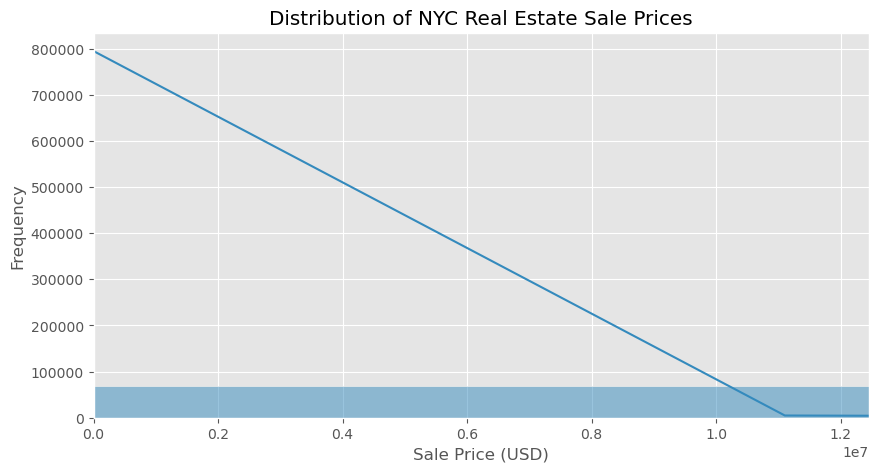

In [264]:
# Set up visualization style
plt.style.use("ggplot")

# 1. Distribution of Sale Prices
plt.figure(figsize=(10, 5))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of NYC Real Estate Sale Prices")
plt.xlabel("Sale Price (USD)")
plt.ylabel("Frequency")
plt.xlim(0, y.quantile(0.99))  # Exclude extreme outliers for better visualization
plt.show()

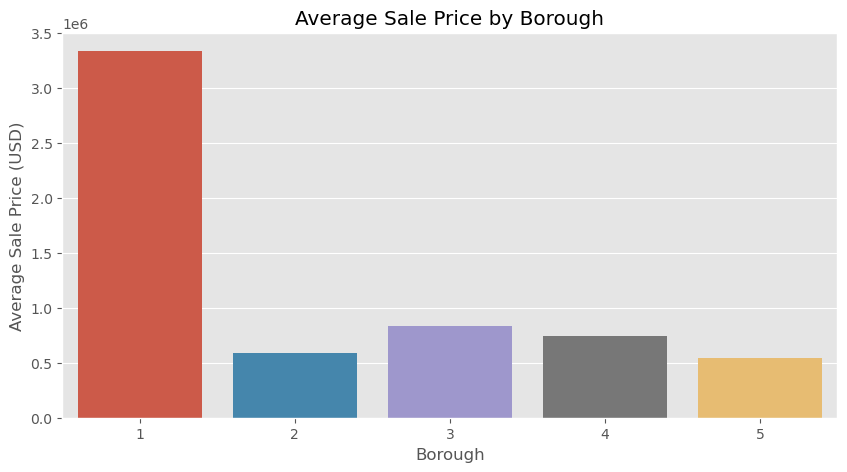

In [265]:
# 2. Average Sale Price by Borough
plt.figure(figsize=(10, 5))
borough_avg_prices = df.groupby("BOROUGH")["SALE PRICE"].mean().sort_values()
sns.barplot(x=borough_avg_prices.index, y=borough_avg_prices.values)
plt.title("Average Sale Price by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Sale Price (USD)")
plt.show()


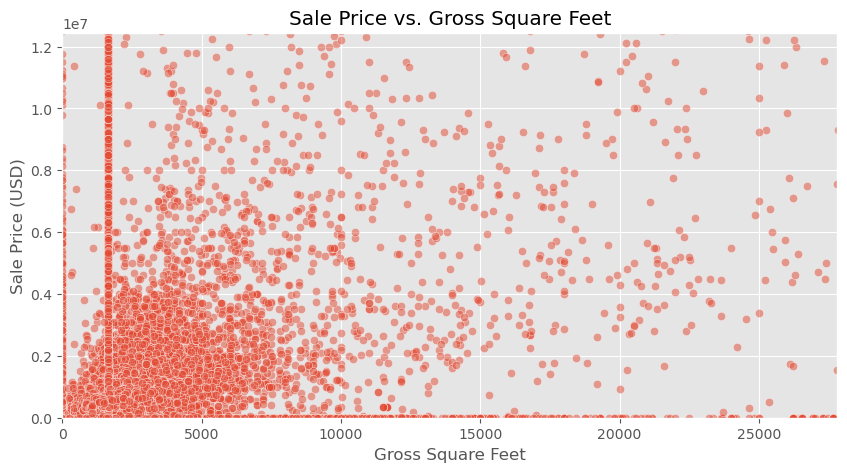

In [266]:
# 3. Relationship Between Square Footage and Sale Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["GROSS SQUARE FEET"], y=y, alpha=0.5)
plt.title("Sale Price vs. Gross Square Feet")
plt.xlabel("Gross Square Feet")
plt.ylabel("Sale Price (USD)")
plt.xlim(0, df["GROSS SQUARE FEET"].quantile(0.99))  # Remove extreme values
plt.ylim(0, y.quantile(0.99))
plt.show()

In [267]:
# log transformation to normalize sale price 
df["LOG_SALE_PRICE"] = np.log1p(df["SALE PRICE"])

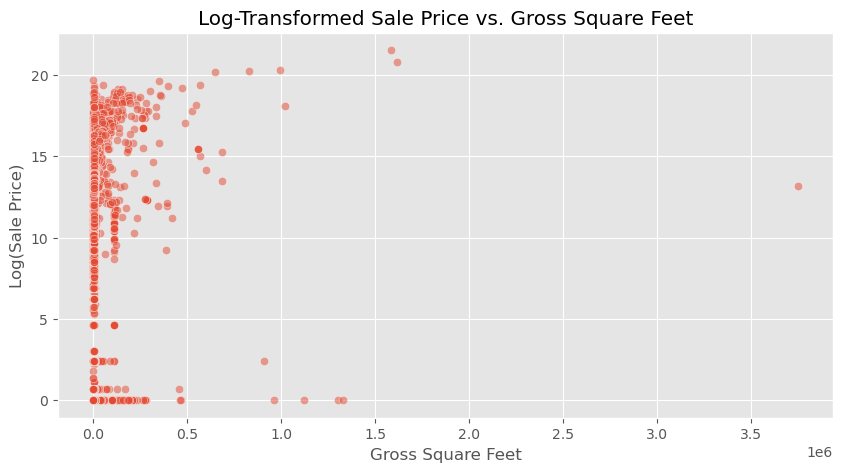

In [268]:
# Sale Price vs. Square Footage More Clearly
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["GROSS SQUARE FEET"], y=df["LOG_SALE_PRICE"], alpha=0.5)
plt.title("Log-Transformed Sale Price vs. Gross Square Feet")
plt.xlabel("Gross Square Feet")
plt.ylabel("Log(Sale Price)")
plt.show()

### one hot encoding

In [269]:
# Check which columns are non-numeric
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", non_numeric_cols)

Categorical columns: ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']


In [169]:
# Make numeric categorical data into string columns
for column in ['BOROUGH', 'ZIP CODE']:
    df[column] = df[column].astype(str)

In [270]:
# Perform one-hot encoding
df = pd.get_dummies(
    df,
    columns=['BOROUGH', 'TAX CLASS AT PRESENT'],
)

In [272]:
# Use Label Encoding (or Target Encoding) if unique values > 15.
le = LabelEncoder()

# List of categorical columns to encode
categorical_cols = ["NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "BUILDING CLASS AT PRESENT", "BUILDING CLASS AT TIME OF SALE"]

# Apply Label Encoding to each column separately
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string to prevent issues

In [273]:
df.head()

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,MONTH,DAY,YEAR,LOG_SALE_PRICE,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
0,1,6,392,6,16,10009,5,0,5,1633.0,6440.0,1900,2,15,6625000.0,7,19,2017,15.706361,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,6,402,21,18,10009,10,0,10,2272.0,6794.0,1913,2,17,3936272.0,9,23,2016,15.185745,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,6,404,55,16,10009,6,0,6,2369.0,4615.0,1900,2,15,8000000.0,11,17,2016,15.894952,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,6,406,32,18,10009,8,0,8,1750.0,4226.0,1920,2,17,3192840.0,9,23,2016,14.976422,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,7,387,153,34,10009,24,0,24,4489.0,18523.0,1920,2,33,16232000.0,11,7,2016,16.602495,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [287]:
# Split the data
y = df['SALE PRICE'].copy()
X = df.drop(['SALE PRICE', 'LOG_SALE_PRICE'], axis=1).copy()

In [288]:
# Identify columns with non-numeric data
non_numeric_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# Check if there are any empty strings in numeric columns
empty_string_counts = (X == "").sum()

non_numeric_cols, empty_string_counts[empty_string_counts > 0]


([], Series([], dtype: int64))

In [289]:
X

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,MONTH,DAY,YEAR,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
0,1,6,392,6,16,10009,5,0,5,1633.0,6440.0,1900,2,15,7,19,2017,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,6,402,21,18,10009,10,0,10,2272.0,6794.0,1913,2,17,9,23,2016,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,6,404,55,16,10009,6,0,6,2369.0,4615.0,1900,2,15,11,17,2016,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,6,406,32,18,10009,8,0,8,1750.0,4226.0,1920,2,17,9,23,2016,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,7,387,153,34,10009,24,0,24,4489.0,18523.0,1920,2,33,11,7,2016,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,251,1,7349,34,13,10309,2,0,2,2400.0,2575.0,1998,1,12,11,28,2016,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
69983,251,1,7349,78,13,10309,2,0,2,2498.0,2377.0,1998,1,12,4,21,2017,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
69984,251,1,7351,60,11,10309,2,0,2,4000.0,1496.0,1925,1,10,7,5,2017,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
69985,251,20,7100,28,82,10309,0,7,7,208033.0,64117.0,2001,4,82,12,21,2016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [290]:
# Scale X 
scaler = StandardScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [291]:
df.columns

Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BLOCK', 'LOT',
       'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'MONTH', 'DAY', 'YEAR',
       'LOG_SALE_PRICE', 'BOROUGH_1', 'BOROUGH_2', 'BOROUGH_3', 'BOROUGH_4',
       'BOROUGH_5', 'TAX CLASS AT PRESENT_ ', 'TAX CLASS AT PRESENT_1',
       'TAX CLASS AT PRESENT_1A', 'TAX CLASS AT PRESENT_1B',
       'TAX CLASS AT PRESENT_1C', 'TAX CLASS AT PRESENT_2',
       'TAX CLASS AT PRESENT_2A', 'TAX CLASS AT PRESENT_2B',
       'TAX CLASS AT PRESENT_2C', 'TAX CLASS AT PRESENT_3',
       'TAX CLASS AT PRESENT_4'],
      dtype='object')

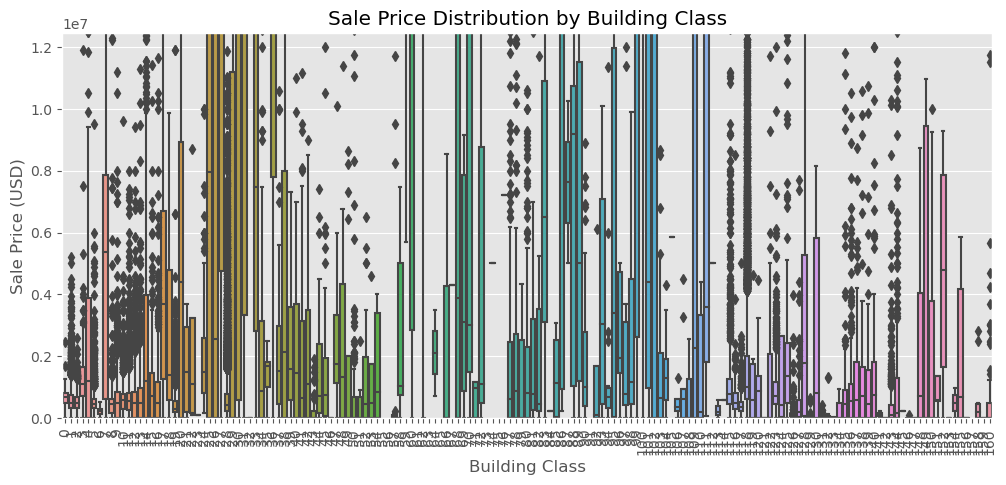

In [292]:
# 4. Boxplot of Sale Prices by Building Class
plt.figure(figsize=(12, 5))
sns.boxplot(x=df["BUILDING CLASS AT TIME OF SALE"], y=y)
plt.xticks(rotation=90)
plt.title("Sale Price Distribution by Building Class")
plt.xlabel("Building Class")
plt.ylabel("Sale Price (USD)")
plt.ylim(0, y.quantile(0.99))
plt.show()

# Training

In [293]:
# Split data into training and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [294]:
# Linear Regression - Baseline model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
print("Baseline R²:", r2_score(y_test, y_pred_lr))

Baseline R²: 0.18434077131492987


In [295]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [296]:
# Make predictions
y_pred = model.predict(X_test)

In [297]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 952188.9284779854
RMSE: 15623204.855509894
R² Score: 0.3611721282463808


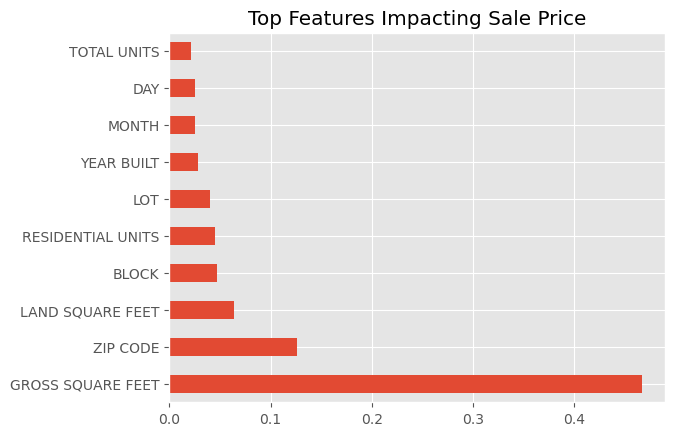

In [298]:
# Show which features most impact price predictions.
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh', title="Top Features Impacting Sale Price")
plt.show()

In [181]:
# Hyperparameter Tuning for XGBoost
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
# learning rate of 0.2, trees w/ max_depth of 5, no more than 50 trees 

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


In [182]:
# Train the final XGBoost model with optimized hyperparameters
final_xgb = XGBRegressor(learning_rate=0.2, max_depth=5, n_estimators=50, random_state=42)
final_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [184]:
# Make predictions
y_pred_final = final_xgb.predict(X_test)

In [185]:
# Evaluate the final model
mae_final = mean_absolute_error(y_test, y_pred_final)
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred_final)

print("Final Model Performance:")
print(f"MAE: {mae_final}")
print(f"RMSE: {rmse_final}")
print(f"R² Score: {r2_final}")

Final Model Performance:
MAE: 1177115.9205053847
RMSE: 20409857.062388737
R² Score: -0.09024355392641348


^ very bad metrics 

In [186]:
#Remove Outliers in Sale Prices
high_cutoff = df["SALE PRICE"].quantile(0.99)  # Remove extreme high prices
low_cutoff = df["SALE PRICE"].quantile(0.01)   # Remove extremely low prices
df = df[(df["SALE PRICE"] >= low_cutoff) & (df["SALE PRICE"] <= high_cutoff)]